In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
import pandas as pd

In [4]:
[int(np.ceil(i)) for i in np.geomspace(13, 147, 30)]

[13,
 15,
 16,
 17,
 19,
 20,
 22,
 24,
 26,
 28,
 31,
 33,
 36,
 39,
 42,
 46,
 50,
 54,
 59,
 64,
 70,
 76,
 82,
 89,
 97,
 106,
 115,
 125,
 136,
 147]

In [2]:
allNs = [int(np.ceil(i)) for i in np.geomspace(13, 147, 30)]
meanerror_Gyzz = []
meanerror_dxGyzz = []
meanerror_3R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
for N in allNs:
    L = 20
    dx = L/N
    FD = FD_file.FD_Class(dx, periodic_boundary=False, order6=True)
    ic = 2*FD.mask
    xyz = np.arange(-L/2, L/2, dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])

    gamma = 1.22
    sign = 1
    s = (2 - gamma)/(2*gamma)
    q = (6-5*gamma)*(2-gamma+2*sign*np.sqrt((9*gamma-1)*(gamma-1)))/(2*gamma*(35*gamma-36))
    k = np.sqrt(-(3*s+3*q-1)/((s+3*q-1)*(3*s*s+(6*q-1)*s-q*q-q)))
    m = np.sqrt(-32*q*q*s/((s-q-1)*(s-q-1)*(3*s+3*q-1)))

    t = 1.5

    A = k*k*t*t*(1+m*m)*Box_ones
    B = m*k*(t**(1+s-q))*np.exp(x)
    C = (t**(2*(s-q)))*np.exp(2*x)
    D = (t**(2*(s+q)))*np.exp(-2*x)

    gdown = np.array([[A, B, Box_zero],
                      [B, C, Box_zero],
                      [Box_zero, Box_zero, D]])
    gdown4 = np.array([[-Box_ones, Box_zero, Box_zero, Box_zero],
                       [Box_zero, gdown[0,0], gdown[0,1], gdown[0,2]],
                       [Box_zero, gdown[1,0], gdown[1,1], gdown[1,2]],
                       [Box_zero, gdown[2,0], gdown[2,1], gdown[2,2]]])
    nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])

    Kdown = (-1/2)*np.array([[2*k*k*t*(1+m*m)*Box_ones, (1+s-q)*m*k*(t**(s-q))*np.exp(x), Box_zero],
                             [(1+s-q)*m*k*(t**(s-q))*np.exp(x), (2*(s-q))*(t**(2*(s-q)-1))*np.exp(2*x), Box_zero],
                             [Box_zero, Box_zero, (2*(s+q))*(t**(2*(s+q)-1))*np.exp(-2*x)]])

    glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
    gdet = RRead.det3(glist)
    gdetth = k*k*(t**(2+4*s))*Box_ones
    gup = RRead.inv3(glist)
    gmixed = np.einsum('ij...,jk...->ik...', gup, gdown)

    RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
    Gudd = RCW.Christoffel_symbol(gdown, gup)
    RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)
    
    Gyzz = Gudd[1,2,2]
    Gyzzth = -np.exp(-3*x)*m*(t**(-1+3*q+s))/k
    meanerror_Gyzz += [np.mean(np.ma.masked_invalid(abs(Gyzz/Gyzzth - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    
    dxGyzz = FD.D3x(Gudd[1,2,2])
    dxGyzzth = 3*np.exp(-3*x)*m*(t**(-1+3*q+s))/k
    meanerror_dxGyzz += [np.mean(np.ma.masked_invalid(abs(dxGyzz/dxGyzzth - 1)[ic:-ic,ic:-ic,ic:-ic]))]

    G        = 1
    kappa    = 8*np.pi*G

    uup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
    udown = np.array([-Box_ones, Box_zero, Box_zero, Box_zero])
    u_axu_b = np.einsum('a...,b...->ab...', udown, udown)
    hdown = gdown4 + u_axu_b
    rho = -(4 + k*k*(4*q*q + m*m*((1 + q - s)**2) - 4*s*(2 + s)))/(4*k*k*kappa*t*t)
    p = (4 - k*k*(12*q*q + 3*m*m*((1 + q - s)**2) + 4*s*(-2 + 5*s)))/(12*k*k*kappa*t*t)
    qx = Box_ones*(-4*q+m*m*(-1-q+s))/(2*kappa*t)
    qy = -(np.exp(x)*m*(1+q-s)*(t**(-2-q+s)))/(2*k*kappa)
    qdown = np.array([Box_zero, qx, qy, Box_zero])
    pixx = Box_ones*(-8 - 3*k*k*m*m*m*m*((1 + q - s)**2) - 8*k*k*(-1 + s)*s + m*m*(4 - k*k*(3 + 3*q*q - 6*q*(-1 + s) - 14*s + 11*s*s)))/(6*kappa)
    pixy = -(np.exp(x)*m*(-4 + k*k*(3 + 6*q + 3*q*q + 3*m*m*((1 + q - s)**2) - 8*s + 5*s*s))*(t**(-1 - q + s)))/(6*k*kappa)
    piyy = np.exp(2*x)*(4 - k*k*(3*m*m*((1 + q - s)**2) + 4*(1 + 3*q - s)*s))*(t**(-2 - 2*q + 2*s))/(6*k*k*kappa)
    pizz = np.exp(-2*x)*(2 + 2*k*k*s*(-1 + 3*q + s))*(t**(2*(-1 + q + s)))/(3*k*k*kappa)
    pidown = np.array([[Box_zero, Box_zero, Box_zero, Box_zero],
                       [Box_zero, pixx, pixy, Box_zero],
                       [Box_zero, pixy, piyy, Box_zero],
                       [Box_zero, Box_zero, Box_zero, pizz]])

    Tdown4 = rho*u_axu_b+p*hdown+np.einsum('a...,b...->ab...', qdown, udown)+np.einsum('b...,a...->ab...', qdown, udown)+pidown

    RicciS3th = -2/(k*k*t*t)
    meanerror_3R += [np.mean(np.ma.masked_invalid(abs(RicciS3/RicciS3th-1)[ic:-ic,ic:-ic,ic:-ic]))]

    Bdict = RCW.Weyl_B(gdown4, nup, gdown, gup, Gudd, Kdown)
    B2th = (9*m*m*(1+q-s)*(1+q-s)+16*(1-s)*(1-s))*abs(gdetth)/(8*(k**4)*(t**(6+4*s)))
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(Bdict['B2']/B2th - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(Bdict['Btrace'][ic:-ic,ic:-ic,ic:-ic])))]

    Kmixed = np.einsum('ij...,jk...->ik...', gup, Kdown)
    K = np.einsum('ab...,ab...->...', gup, Kdown)
    Edict = RCW.Weyl_E(gdown, gup, RicciS3, RicciTdown, Kdown, kappa, rho, 0.0, Tdown4[1:,1:])
    c1 = (1 + q - s)
    c2 = (-1 + s)
    E2th = Box_ones*(16 + 16*k*k*(-2*q*q + m*m*c1*c1) + (k**4)*(16*q*q*(q*q + 3*c2*c2) + m*m*(11*q*q - 18*q*c2 + 3*c2*c2)*c1*c1 + 4*(m**4)*(c1**4)))/(24*((k*t)**4))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(Edict['E2']/E2th - 1)[ic:-ic,ic:-ic,ic:-ic]))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(Edict['Etrace'][ic:-ic,ic:-ic,ic:-ic])))]
    del Bdict, Edict, RicciS3, RicciTdown, Gudd
    print('N={}, error={:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}'.format(N, meanerror_3R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1]))


N=13, error=1.57e+03, 1.36e+03, 7.70e-34, 7.72e+06, 1.42e-14
N=15, error=1.33e+02, 1.16e+02, 8.43e-34, 5.55e+04, 2.37e-15
N=16, error=4.94e+01, 4.35e+01, 1.24e-33, 7.79e+03, 1.55e-15
N=17, error=2.11e+01, 1.87e+01, 9.10e-34, 1.47e+03, 6.22e-16
N=19, error=5.46e+00, 4.91e+00, 3.44e-33, 1.11e+02, 3.17e-16
N=20, error=3.17e+00, 2.88e+00, 2.20e-33, 4.22e+01, 7.63e-17
N=22, error=1.30e+00, 1.19e+00, 1.88e-32, 9.66e+00, 9.44e-17
N=24, error=6.30e-01, 5.79e-01, 9.68e-33, 3.38e+00, 7.40e-17
N=26, error=3.41e-01, 3.15e-01, 2.35e-32, 1.52e+00, 1.05e-16
N=28, error=1.99e-01, 1.84e-01, 3.22e-32, 8.03e-01, 1.30e-16
N=31, error=9.84e-02, 9.12e-02, 1.75e-32, 3.65e-01, 1.18e-16
N=33, error=6.46e-02, 5.99e-02, 8.34e-32, 2.33e-01, 1.12e-16
N=36, error=3.64e-02, 3.37e-02, 1.90e-31, 1.28e-01, 1.07e-16
N=39, error=2.16e-02, 2.01e-02, 7.09e-32, 7.52e-02, 9.28e-17
N=42, error=1.35e-02, 1.25e-02, 2.23e-31, 4.64e-02, 1.04e-16
N=46, error=7.57e-03, 7.02e-03, 3.18e-31, 2.60e-02, 8.80e-17
N=50, error=4.48e-03, 4.

In [ ]:
idec = -1

phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
lw = 2

plt.loglog(allNs, meanerror_Gyzz, 'C3', label=r'$v=\Gamma^{y}_{zz}$')
yplot_4th_order_decrease = [meanerror_Gyzz[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs, meanerror_dxGyzz, 'C5', label=r'$v=\partial_{x}\Gamma^{y}_{zz}$')
yplot_4th_order_decrease = [meanerror_dxGyzz[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs, meanerror_3R, 'C0', label=r'$v={}^{(3)}R$')
yplot_4th_order_decrease = [meanerror_3R[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw)

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=lw, label='Truncation error')

plt.legend(loc=3, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.ylim(1e-4, 5e-1)
plt.xticks([30,40,60,80,100,130], ['30','40','60','80','100','130'])
plt.xlim(25, 160)
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
plt.savefig('Plots/BianchiVI_Slicing.pdf')

In [3]:
data = np.array([allNs, meanerror_Gyzz, meanerror_dxGyzz, meanerror_3R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', 'Gyzz', 'dxGyzz', '3R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/BianchiVI_Slicing_o6R.csv')

<IPython.core.display.Javascript object>


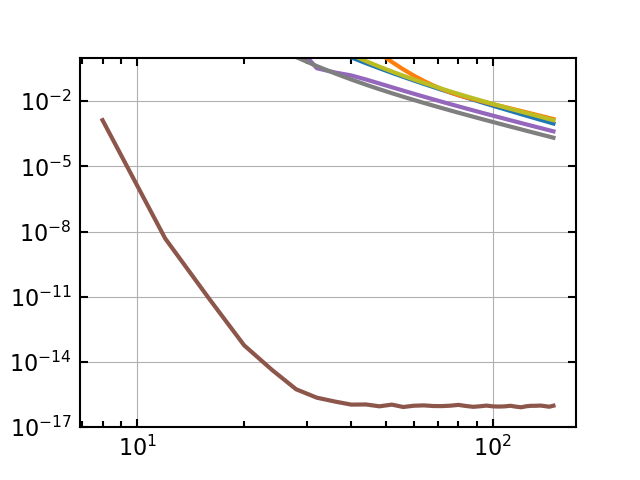

(1e-17, 1.0)

In [7]:
spacetime='BianchiVI'
fs = pd.read_csv('ErrorData/'+spacetime+'_Slicing.csv')
plt.loglog(fs['N'], fs['3R'], 'C0')#, label=r'$v={}^{(3)}R$')
plt.loglog(fs['N'], fs['E2'], 'C1')#, label=r'$v=E^2$')
plt.loglog(fs['N'], fs['B2'], 'C4')#, label=r'$v=B^2$')
plt.loglog(fs['N'], fs['ET'], 'C5')#, label=r'$v=E^T$')
plt.loglog(fs['N'], fs['BT'], 'C6')#, label=r'$v=B^T$')
plt.loglog(fs['N'], fs['Gyzz'], 'C7', label=r'$v=\Gamma^{y}_{zz}$')
plt.loglog(fs['N'], fs['dxGyzz'], 'C8', label=r'$v=\partial_{x}\Gamma^{y}_{zz}$')
plt.grid()
plt.ylim(1e-17, 1e0)